In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(
    os.path.join(os.path.dirname('__file__'), '..')))

In [2]:
# %pip install -r ../requirements.txt

In [3]:
from src.encoding.encoders import *
from src.encoding.tools import create_encoding_pipeline
from src.models.sklearn_api_model import save_object, Model
from src.models.sklearn_api_models_config import get_model
from src.datasets.base_tabular_dataset import BaseTabularDataset
from src.experiments.base_experiment import BaseExperiment
import src.features as ft
import logging
import pandas as pd
import pathlib

In [4]:
# Define a logger used by all modules
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO, encoding="utf-8",
                    format="%(name)s %(asctime)s: %(levelname)s: %(message)s", handlers=[logging.StreamHandler()])

In [5]:
# Define the root directory of the project
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
root_dir = pathlib.Path(root_dir)

In [6]:
# Define the configuration for the fetching of the data
fetch_config = {
    "data_start": '01-01-2017',
    "data_stop": '31-12-2023',
    'data_dir': root_dir / 'data',
    "locations": ['CHU Dijon', 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard', 'CH Chaumont', 'CH Langres', 'HNFC']
    }

In [7]:
# Select the features to be used in the dataset
ars_features_class = [
    ft.HospitalFeatures,
    # ft.AirQualityFeatures,
    # ft.EpidemiologicalFeatures,
    # ft.FireFightersFeatures(include_calls=False),
    # ft.GoogleTrendFeatures,
    # ft.MeteorologicalFeatures,
    ft.SociologicalFeatures,
    # ft.SportsCompetitionFeatures,
    # ft.TrafficFeatures
    ]

In [8]:
# Select the target columns to be predicted
target_colomns = ['nb_emmergencies']
# target_colomns = ['nb_vers_hospit']
# target_colomns = ['nb_hospit_np_adults%%J+1%%mean_7J']

In [9]:
# Define an encoding scheme to create the encoding pipeline
encoders_dict = {
    'number': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='mean')],
            'encoders': [
                ne.StandardScaler(),
            ]
        }
    },
    'category': {
        'as_category': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'datetime': {
        'as_number': {
            'imputers': [de.DateFeatureExtractor()],
            'encoders': [
                ne.CyclicalFeatures(drop_original=True)
            ]
        },
        'as_category': {
            'imputers': [de.DateFeatureExtractor(dtype='category')],
            'encoders': [
                ne.MultiTargetEncoder(drop_invariant=True, return_df=True),
            ]
        }
    },
    'boolean': {
        'as_number': {
            'imputers': [imputers.SimpleImputer(strategy='most_frequent')],
             'encoders': [ne.BooleanEncoder()]
         }

    }
}

In [10]:
# Create the encoding pipeline
pipeline = create_encoding_pipeline(encoders_dict)

Creating encoding pipeline


In [11]:
pipeline

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer())])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('standardscaler',
                                                                                  StandardScaler())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe88a057d00>),
                                ('pipe...
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe88a0578b0>),
                                ('pipeline-5',
                                 Pipeline(steps=[('featureunion-1',
                                                  FeatureUnion(transformer_list=[('simpleimputer',
                                                                                  SimpleImputer(strategy='most_frequent'))])),
                                                 ('featureunion-2',
                                                  FeatureUnion(transformer_list=[('booleanencoder',
                                                                                  BooleanEncoder())]))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fe88a0574c0>)],
                  verbose=True)

In [12]:
# Define the splitting scheme to create the sets
split_config = {'test_size': 0.2, 'val_size': 0.2, 'shuffle': False}

In [13]:
features_config_get = {}

In [14]:
# Define the configuration of the dataset
dataset_config = {
    'from_date': '01-01-2019',
    'to_date': '30-12-2023',
    'locations': ['CHU Dijon', 'CHU Besançon', 'CH Beaune', 'CH Semur', 'CH Chatillon Montbard'],
    'axis': 'columns',
    'shift': range(1, 7, 1),
    'rolling_window': [14, 31, 365],
    'freq': '1D',
    'split_config': split_config,
    'create_X_y': True,
    'encoding_pipeline': pipeline,
    'targets_names': target_colomns,
    'targets_shift': -3,
    'targets_rolling_window': 3,
    'targets_history_shifts': range(7, 14, 1),
    'targets_history_rolling_windows': [7, 14, 31, 365],
    'targets_locations': ['CHU Dijon'],
    'drop_constant_thr':0.65,
    'data_dir': root_dir / 'data'
    }

In [15]:
# Create the dataset and fetch the data from the source then call get_dataset() method to fill the different attributes (X and y) of the different sets, and their encodings
arsTabularDataset = BaseTabularDataset(features_classes=ars_features_class, logger=logger, fetch_config=fetch_config, getter_config=dataset_config)

root 2024-10-30 15:19:44,516: INFO: Initialisation de la classe BaseTabularDataset
root 2024-10-30 15:19:44,520: INFO: Initialisation des features
root 2024-10-30 15:19:44,521: INFO: Fetching data for hospitalfeatures at CHU Dijon
root 2024-10-30 15:19:44,821: INFO: Fetching data for hospitalfeatures at CHU Besançon
root 2024-10-30 15:19:45,152: INFO: Fetching data for hospitalfeatures at CH Beaune
root 2024-10-30 15:19:45,506: INFO: Fetching data for hospitalfeatures at CH Semur
root 2024-10-30 15:19:45,847: INFO: Fetching data for hospitalfeatures at CH Chatillon Montbard
root 2024-10-30 15:19:46,160: INFO: Fetching data for hospitalfeatures at CH Chaumont
root 2024-10-30 15:19:46,484: INFO: Fetching data for hospitalfeatures at CH Langres
root 2024-10-30 15:19:46,871: INFO: Fetching data for hospitalfeatures at HNFC
root 2024-10-30 15:19:47,196: INFO: Fetching data for sociologicalfeatures at CHU Dijon
root 2024-10-30 15:19:47,513: INFO: Fetching data for sociologicalfeatures at CHU

Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-10-30 15:19:52,385: INFO: Augmentation des features...
root 2024-10-30 15:19:52,391: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-10-30 15:19:52,396: INFO: Augmentation des features...
root 2024-10-30 15:19:52,439: INFO: Creating the target columns as a rolling mean of nb_emmergencies_CHU Dijon on 3 rows shifted by -3
root 2024-10-30 15:19:52,441: INFO: Creating target history columns...
root 2024-10-30 15:19:52,444: INFO: Rolling windows will start from 6 samples before to n days before this starting sample
root 2024-10-30 15:19:52,489: INFO: Calculating train/val/test sets and encodings...


Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped 0 constant columns from both sets: []
X shape: (1162, 491), y shape: (1162, 1)
[ColumnTransformer] .... (1 of 3) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (2 of 3) Processing pipeline-4, total=   0.0s
[ColumnTransformer] .... (3 of 3) Processing pipeline-5, total=   0.1s
Index(['nb_emmergencies_CHU Dijon', 'nb_emmergencies%%J-1_CHU Dijon',
       'nb_emmergencies%%J-2_CHU Dijon', 'nb_emmergencies%%J-3_CHU Dijon',
       'nb_emmergencies%%J-4_CHU Dijon', 'nb_emmergencies%%J-5_CHU Dijon',
       'nb_emmergencies%%J-6_CHU Dijon', 'nb_emmergencies%%mean_14J_CHU Dijon',
       'nb_emmergencies%%std_14J_CHU Dijon',
       'nb_emmergencies%%mean_31J_CHU Dijon',
       'nb_emmergencies%%std_31J_CHU Dijon',
       'nb_emmergencies%%mean_365J_CHU Dijon',
       'nb_emmergencies%%std_365J_CHU Dijon', 'nb_emmergencies_CHU Besançon',
       'nb_emmergencies%%J-1_CHU Besançon',
       'nb_emmerg

In [16]:
df = arsTabularDataset.enc_data

# Identifie les colonnes contenant des NaN
cols_with_nan = df.columns[df.isna().any()].tolist()
print("Colonnes contenant des NaN:", cols_with_nan)

# Affiche la liste des index des lignes contenant des NaN pour chaque colonne
nan_indices = {col: df[df[col].isna()].index.tolist() for col in cols_with_nan}
nan_indices

Colonnes contenant des NaN: []


{}

In [17]:
# print(arsTabularDataset.data.columns.to_list())
# Define the model parameters
model_params = {
    'early_stopping_rounds': 10,
    # 'eval_set': [(arsTabularDataset.enc_X_val, arsTabularDataset.y_val)], # TODO: to be set in the experiment's run method
    'verbosity': 0,
    'n_estimators': 10000,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    # 'multi_strategy': 'one_output_per_tree',
    # 'multi_strategy': 'multi_output_tree' 
}

In [18]:
metrics = ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] # first one is used for evaluation and everywhere a sinlge metric is used, the rest are used for testing

In [19]:
# Create the model
model = get_model(model_type='xgboost', name='XGBoost', device='cuda', task_type='regression', test_metrics=metrics, params=model_params)

In [20]:
# Create the experiment
ars_experiment = BaseExperiment(logger=logger, dataset=arsTabularDataset, model=model)

In [21]:
# Set the model fitting config
grid_params = {
    'max_depth': [3, 5, 7, 9, 11],
}

In [22]:
fit_params = {
    'verbose': 0,
}

In [23]:
model_config={"optimization": "grid", "grid_params": grid_params, "fit_params": fit_params}

2024/10/30 15:19:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
root 2024-10-30 15:19:53,496: INFO: Running the experiment...
root 2024-10-30 15:19:53,513: INFO: => Recherche des 68 features les + pertinentes
root 2024-10-30 15:19:53,514: INFO:    - Grande variance
root 2024-10-30 15:19:53,525: INFO:    - Coefficient de corrélation de Pearson
root 2024-10-30 15:19:53,718: INFO:    - Coefficient de corrélation de Kendall
root 2024-10-30 15:19:54,112: INFO:    - Coefficient de corrélation de Spearman
root 2024-10-30 15:19:54,340: INFO:    - Random forests
root 2024-10-30 15:19:54,853: INFO:    - Régression linéaire
root 2024-10-30 15:19:54,962: INFO: [  0   1   4   6   8   9  10  17  22  24  29  31  65  66  67  71  73  99
 111 120 127 129 163 164 165 169 171 197 209 218 225 227 261 262 263 267
 269 295 307 316 323 325 359 360 361 365 367 393 405 414 416 421 423 457
 458 459 463 465 491 503 517 519 520 559 571 572 586 587]
root 2024-10-30 15:19:54

Fitting estimator with 588 features.


Fitting estimator with 488 features.


Fitting estimator with 388 features.
Fitting estimator with 288 features.


Fitting estimator with 188 features.
Fitting estimator with 88 features.


root 2024-10-30 15:20:00,128: INFO: => Exploration des features
root 2024-10-30 15:20:00,680: INFO: ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] With target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-13 number 0: inf -> 28.076930269018288
('mae', 14.94172605577406)	('mse', 395.7161568700243)	('rmse', 19.892615636713646)	('w_rmse', 28.076930269018288)	('pw_rmse', 30.05964574146093)
root 2024-10-30 15:20:00,975: INFO: ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] With nb_emmergencies%%J-1_CHU Dijon number 1: 28.076930269018288 -> 23.73170201646884
('mae', 12.55736587859772)	('mse', 269.9480679818816)	('rmse', 16.43009640817368)	('w_rmse', 23.73170201646884)	('pw_rmse', 23.99363923107913)
root 2024-10-30 15:20:01,742: INFO: ['w_rmse', 'pw_rmse', 'rmse', 'mae', 'mse'] With target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-7 number 3: 23.73170201646884 -> 23.094654099324533
('mae', 12.38187274304065)	('mse', 258.0687715097787)	('rmse', 16.06451902516159)	('w_rmse', 23.094654099324533)	('pw_rms

Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []
Dropped columns with zero variance: []


root 2024-10-30 15:20:38,951: INFO: Augmentation des features...
root 2024-10-30 15:20:38,958: INFO: Getting data for sociologicalfeatures from 2019-01-01 00:00:00 to 2023-12-30 00:00:00, at a 1D frequency
root 2024-10-30 15:20:38,964: INFO: Augmentation des features...
root 2024-10-30 15:20:39,047: INFO: Creating the target columns as a rolling mean of nb_emmergencies_CHU Dijon on 3 rows shifted by -3
root 2024-10-30 15:20:39,049: INFO: Creating target history columns...
root 2024-10-30 15:20:39,053: INFO: Rolling windows will start from 6 samples before to n days before this starting sample
root 2024-10-30 15:20:39,082: WARNING: Target target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J not in features_names, adding it to continue
root 2024-10-30 15:20:39,083: INFO: Calculating train/val/test sets and encodings...


Dropped columns with zero variance: []
Dropped 0 constant columns from both sets: []
X shape: (1162, 1), y shape: (1162, 1)
[ColumnTransformer] .... (1 of 2) Processing pipeline-3, total=   0.0s
[ColumnTransformer] .... (2 of 2) Processing pipeline-4, total=   0.0s
Index(['target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-13',
       'nb_emmergencies%%J-1_CHU Dijon',
       'target_nb_emmergencies_CHU Dijon%%J+3%%mean_3J%%J-7',
       'nb_emmergencies%%std_365J_CH Semur', 'nb_emmergencies%%J-2_CHU Dijon',
       'nb_emmergencies%%mean_14J_CH Semur',
       'nb_emmergencies%%std_365J_CH Beaune',
       'nb_emmergencies%%std_365J_CHU Besançon',
       'nb_emmergencies%%std_14J_CH Semur', 'nb_emmergencies_CH Semur',
       'nb_emmergencies%%J-5_CHU Dijon', 'nb_emmergencies%%J-1_CH Beaune'],
      dtype='object')


root 2024-10-30 15:21:08,011: INFO: Model fitted.
root 2024-10-30 15:21:11,843: INFO: Scoring the model...
root 2024-10-30 15:21:11,860: INFO: Testing the model...
root 2024-10-30 15:21:11,905: INFO: Plotting the results...
matplotlib.legend 2024-10-30 15:21:11,916: WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024/10/30 15:21:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run run_35 at: http://127.0.0.1:8080/#/experiments/227003089804487542/runs/f158040d68024017b1c6f6957c44ebfa.
2024/10/30 15:21:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/227003089804487542.
2024/10/30 15:21:12 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/10/30 15:21:12 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


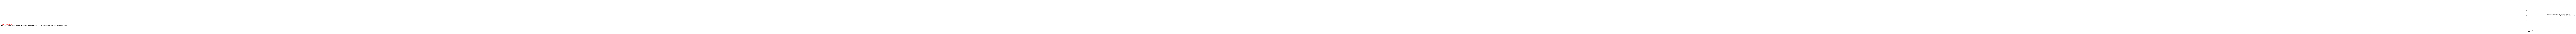

In [24]:
# Run the experiment
ars_experiment.run(dataset_config=dataset_config, model_config=model_config, find_best_features=True)

In [25]:
X_train = ars_experiment.dataset.enc_X_train
X_test = ars_experiment.dataset.enc_X_test
X_val = ars_experiment.dataset.enc_X_val

y_train = ars_experiment.dataset.y_train
y_test = ars_experiment.dataset.y_test
y_val = ars_experiment.dataset.y_val

X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
X_val.to_csv("X_val.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)
y_val.to_csv("y_val.csv", index=False)

In [26]:
# model = ars_experiment.model

In [27]:
# dataset = arsTabularDataset

In [28]:
# dataset.enc_data.head()

In [29]:
# df = dataset.enc_data
# df

In [30]:
# from scipy.cluster import hierarchy
# from scipy.spatial.distance import squareform
# from scipy.stats import spearmanr
# import matplotlib.pyplot as plt
# import numpy as np

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# corr = spearmanr(X).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

In [31]:
# from shap_select import shap_select

In [32]:
# selected_features_df = shap_select(model.best_estimator_, X_val, y_val, task="regression", threshold=0.05)

In [33]:
# X_train

In [34]:
# bst = model.best_estimator_.get_booster()

In [35]:
# importance_gain = bst.get_score(importance_type='gain')
# importance_cover = bst.get_score(importance_type='cover')
# importance_weight = bst.get_score(importance_type='weight')

In [36]:
# df_cover = pd.DataFrame(importance_cover, index=[0]).T
# df_gain = pd.DataFrame(importance_gain, index=[0]).T
# df_weight = pd.DataFrame(importance_weight, index=[0]).T

In [37]:
# df_cover.shape

In [38]:
# df_cover.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_gain.sort_values(by=0).plot(kind="barh", figsize=(15,20))
# df_weight.sort_values(by=0).plot(kind="barh", figsize=(15,20))

In [39]:
# model.shapley_additive_explanation(X_test, outname='shap_b', dir_output='.', mode="beeswarm", figsize=(500000, 200000))

In [40]:
# from collections import defaultdict

# cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# selected_features_names = X.columns[selected_features]
# X_train_sel = X_train[selected_features_names]
# X_test_sel = X_test[selected_features_names]
# X_val_sel = X_val[selected_features_names]
# model_config['fit_params'].update({'eval_set': [(X_val_sel, y_val[target]) for target in ars_experiment.dataset.targets_names]})
# model.fit(X_train_sel, y_train, **model_config)
# print(
#     "Baseline accuracy on test data with features removed:"
#     f" {model.score(X_test_sel, y_test):.2}"
# )


In [41]:
# import matplotlib

# from sklearn.inspection import permutation_importance
# from sklearn.utils.fixes import parse_version


# def plot_permutation_importance(clf, X, y, ax):
#     result = permutation_importance(clf, X, y, n_repeats=10, random_state=42)
#     perm_sorted_idx = result.importances_mean.argsort()

#     # `labels` argument in boxplot is deprecated in matplotlib 3.9 and has been
#     # renamed to `tick_labels`. The following code handles this.
#     tick_labels_parameter_name = (
#         "tick_labels"
#         if parse_version(matplotlib.__version__) >= parse_version("3.9")
#         else "labels"
#     )
#     tick_labels_dict = {tick_labels_parameter_name: X.columns[perm_sorted_idx]}
#     ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
#     ax.axvline(x=0, color="k", linestyle="--")
#     return ax


In [42]:
# fig, ax = plt.subplots(figsize=(7, 6))
# plot_permutation_importance(model, X_test_sel, y_test, ax)
# ax.set_title("Permutation Importances on selected subset of features\n(test set)")
# ax.set_xlabel("Decrease in accuracy score")
# ax.figure.tight_layout()
# plt.show()

In [43]:
# get the first line of x train
# X_train_sel[:1]

In [44]:
# y_train[:1]

In [45]:
# model.predict(X_train_sel[:1])

In [46]:
# import shap
# shap.initjs()
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)
# single_explanation = explainer_xgb.shap_values(X_train_sel[:1])
# shap.summary_plot(single_explanation, X_test_sel, plot_type="bar")


In [47]:
# X_train.columns

In [48]:
# model = ars_experiment.model

In [49]:
# X_train = ars_experiment.dataset.enc_X_train
# X_test = ars_experiment.dataset.enc_X_test
# X_val = ars_experiment.dataset.enc_X_val

# y_train = ars_experiment.dataset.y_train
# y_test = ars_experiment.dataset.y_test
# y_val = ars_experiment.dataset.y_val

In [50]:
# explainer_xgb = shap.TreeExplainer(model.best_estimator_)

In [51]:
# X_train

In [52]:
# shap_values_xgb = explainer_xgb.shap_values(X_train)


In [53]:
# shap.plots.force(explainer_xgb.expected_value, shap_values_xgb)

In [54]:
# shap.dependence_plot('inc_grippe', shap_values_xgb, X_train_sel)

In [55]:
# shap_values_xgb